In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.models import vgg16
from torch.autograd import Variable
from torch.optim import Adam
from torch.backends import cudnn

from datasets import StyleTransferDataset
from models import FastStyleTransfer2, LossNetwork
from criterion import PerceptualLoss
from train_utils import fit, prep_img, save_checkpoint

In [2]:
cudnn.benchmark = True # Speedup with uniform sized inputs

In [3]:
path = '/home/austin/data/MSCOCO/val2014'
style_path = '/home/austin/data/Starry_Night.jpg'

In [32]:
tr_mean, tr_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
image_transforms = transforms.Compose([transforms.Scale(256),
                                       transforms.CenterCrop(256),
                                       transforms.ToTensor(),
                                       transforms.Normalize(tr_mean, tr_std)])

postpb = transforms.ToPILImage()

def postp(tensor): # to clip results in the range [0,1]
    mu = torch.Tensor(tr_mean).view(-1,1,1)
    sigma = torch.Tensor(tr_std).view(-1,1,1)
    img = postpb((tensor * sigma + mu).clamp(0, 1))
    return img

In [33]:
train = StyleTransferDataset(path, style_path, transforms=image_transforms, limit=2000)

## Summary
- Input Image
- Check Content Loss vs Original Image and Style Loss vs Style Image

In [6]:
train[1][0]


( 0 ,.,.) = 
 -1.1589 -1.3473 -1.5185  ...  -1.4158 -1.4843 -1.3130
 -1.0733 -1.4158 -1.3987  ...  -1.4158 -1.4843 -1.4843
 -1.0904 -1.2617 -1.4329  ...  -1.1247 -1.2788 -1.1589
           ...             ⋱             ...          
  0.1768  0.1426  0.1426  ...  -1.0904 -1.2445 -1.1760
 -0.0458  0.1939  0.0227  ...  -0.9534 -1.0733 -1.0733
 -0.1314  0.1426  0.1254  ...  -1.1932 -0.8164 -0.5938

( 1 ,.,.) = 
 -0.9503 -1.1604 -1.2654  ...  -1.1779 -1.1253 -1.0903
 -0.9503 -1.1253 -1.0903  ...  -1.0903 -1.0903 -1.1604
 -0.8102 -0.9678 -1.2129  ...  -0.7752 -0.9503 -0.8978
           ...             ⋱             ...          
  0.8704  0.7129  0.8704  ...  -0.4776 -0.4076 -0.3200
  0.7129  0.8704  0.8179  ...  -0.3725 -0.3200 -0.3901
  0.7829  0.9405  0.8179  ...  -0.4951 -0.1450  0.1877

( 2 ,.,.) = 
 -0.7064 -0.8633 -0.9678  ...  -0.7238 -0.5844  0.0431
 -0.6541 -0.8981 -0.9156  ...  -0.6541 -0.7238 -0.5670
 -0.6541 -0.6715 -0.8981  ...  -0.5844 -0.8458 -0.6715
           ...         

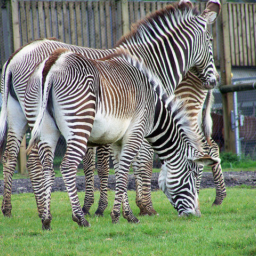

In [7]:
postp(train[1][0])

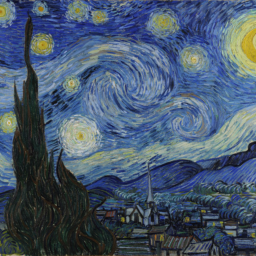

In [8]:
postp(train[0][1])

<img src="styletransfernet.png" />

## Transformation Network

In [9]:
stylenet = FastStyleTransfer2()
stylenet.cuda()

FastStyleTransfer2 (
  (reflection_padding): ReflectionPad2d (40, 40, 40, 40)
  (conv1): ConvInstanceRelu (
    (reflection_pad): ReflectionPad2d (4, 4, 4, 4)
    (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (instancenorm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv2): ConvInstanceRelu (
    (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (instancenorm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (conv3): ConvInstanceRelu (
    (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (instancenorm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (resblock): ResInstanceCenterCrop (
    (conv3x3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (instancenorm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  )
  (upblock1): UpBlock (
    (upsample): Upsample(scale_factor=

## Loss Network

In [10]:
lossnet = LossNetwork()
lossnet.parameters()
for param in lossnet.parameters():
    param.requires_grad = False
lossnet.eval()
lossnet.cuda()

LossNetwork (
  (relu1_2): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
  )
  (relu2_2): Sequential (
    (0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU (inplace)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU (inplace)
  )
  (relu3_3): Sequential (
    (0): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU (inplace)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU (inplace)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
  )
  (relu4_3): Sequential (
    (0): MaxPool2d (size=(2, 2), stride

In [11]:
criterion = PerceptualLoss(lossnet)
optimizer = Adam(stylenet.parameters(), lr=1e-3)

## Train

Train on 2000 samples


[ loss: 15.8302 | style loss: 3.8919 | content loss: 11.9383 ]



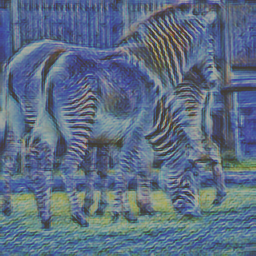

In [12]:
history = fit(stylenet, train, criterion, optimizer, batch_size=4, num_workers=8)
out = stylenet(prep_img(train[1][0]))
postp(out.data.cpu()[0])

Train on 2000 samples


[ loss: 12.3612 | style loss: 3.2604 | content loss: 9.1008 ]



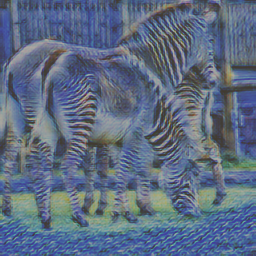

In [13]:
history = fit(stylenet, train, criterion, optimizer, batch_size=4, num_workers=8)
out = stylenet(prep_img(train[1][0]))
postp(out.data.cpu()[0])

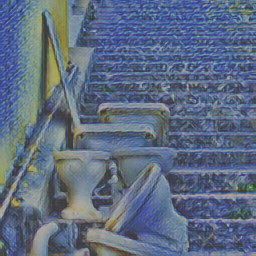

In [14]:
out = stylenet(prep_img(train[16][0]))
postp(out.data.cpu()[0])

In [15]:
save_checkpoint(stylenet.state_dict(), optimizer.state_dict(),'ST2_Epoch_COCOS.pth.tar')

Train on 2000 samples


[ loss: 11.3679 | style loss: 3.2821 | content loss: 8.0858 ]


[ loss: 10.7258 | style loss: 3.3099 | content loss: 7.4160 ]


[ loss: 10.3263 | style loss: 3.3335 | content loss: 6.9928 ]


[ loss: 10.0301 | style loss: 3.3249 | content loss: 6.7052 ]


[ loss: 9.8228 | style loss: 3.3275 | content loss: 6.4954 ]



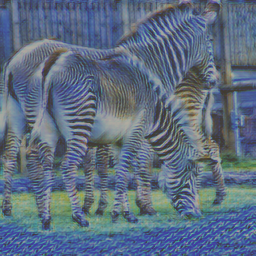

In [16]:
history = fit(stylenet, train, criterion, optimizer, batch_size=4, num_workers=8, nb_epoch=5)
out = stylenet(prep_img(train[1][0]))
postp(out.data.cpu()[0])

In [17]:
save_checkpoint(stylenet.state_dict(), optimizer.state_dict(),'ST2_Epoch7_COCOS.pth.tar')

Train on 2000 samples


[ loss: 9.6555 | style loss: 3.3186 | content loss: 6.3369 ]


[ loss: 9.5405 | style loss: 3.3145 | content loss: 6.2260 ]


[ loss: 9.4309 | style loss: 3.2994 | content loss: 6.1316 ]


[ loss: 9.3550 | style loss: 3.2919 | content loss: 6.0632 ]


[ loss: 9.2827 | style loss: 3.2802 | content loss: 6.0024 ]


[ loss: 9.2244 | style loss: 3.2717 | content loss: 5.9527 ]


[ loss: 9.1744 | style loss: 3.2618 | content loss: 5.9127 ]


[ loss: 9.1091 | style loss: 3.2487 | content loss: 5.8604 ]


[ loss: 9.0838 | style loss: 3.2442 | content loss: 5.8395 ]


[ loss: 9.0448 | style loss: 3.2407 | content loss: 5.8041 ]



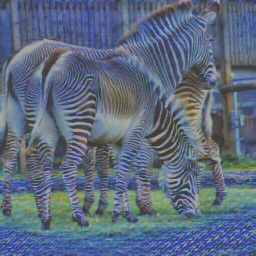

In [18]:
history = fit(stylenet, train, criterion, optimizer, batch_size=4, num_workers=8, nb_epoch=10)
out = stylenet(prep_img(train[1][0]))
postp(out.data.cpu()[0])

In [19]:
def anneal_lr(optimizer, decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] /= decay

In [20]:
anneal_lr(optimizer, 2)

In [35]:
image_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(tr_mean, tr_std)])

In [36]:
train = StyleTransferDataset(path, style_path, transforms=image_transforms)

In [29]:
save_checkpoint(stylenet.state_dict(), optimizer.state_dict(),'weights/ST2_Epoch17_COCOS.pth.tar')